<h1><center>Final Project</center></h1>
<h3><center>Zining Wang, Wenxuan Wang, Wenda Zheng</center></h3>   

First, we read and preprocess the data:

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train.head()

print train.shape

# Adjust House Price based on CPI index, Convert to 2010 December dollars (CPI indices are from Bureau of Labor Statistics)
train.ix[(train.YrSold == 2010) & 
         ((train.MoSold == 7)|(train.MoSold == 6)|(train.MoSold <= 4)),
         'SalePrice'] = train.SalePrice * 1.01
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold == 1)|(train.MoSold == 6)|(train.MoSold <= 4)),
         'SalePrice'] = train.SalePrice * 1.04
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold == 2)|(train.MoSold == 3)|(train.MoSold == 4)),
         'SalePrice'] = train.SalePrice * 1.03
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold == 5)|(train.MoSold == 6)|(train.MoSold == 7)|(train.MoSold == 8)),
         'SalePrice'] = train.SalePrice * 1.02
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold >= 9)),
         'SalePrice'] = train.SalePrice * 1.01
train.ix[(train.YrSold == 2008) & 
         ((train.MoSold == 1)|(train.MoSold == 12)),
         'SalePrice'] = train.SalePrice * 1.04
train.ix[(train.YrSold == 2008) & 
         ((train.MoSold == 3)|(train.MoSold == 11)),
         'SalePrice'] = train.SalePrice * 1.03
train.ix[(train.YrSold == 2008) & 
         ((train.MoSold == 5)|(train.MoSold == 10)),
         'SalePrice'] = train.SalePrice * 1.01
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 1)|(train.MoSold == 2)),
         'SalePrice'] = train.SalePrice * 1.08
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 3)),
         'SalePrice'] = train.SalePrice * 1.07
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 4)),
         'SalePrice'] = train.SalePrice * 1.06
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 5)|(train.MoSold == 6)|(train.MoSold == 7)|(train.MoSold == 8)|(train.MoSold == 9)|(train.MoSold == 10)),
         'SalePrice'] = train.SalePrice * 1.05
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 11)|(train.MoSold == 12)),
         'SalePrice'] = train.SalePrice * 1.04
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 1)),
         'SalePrice'] = train.SalePrice * 1.11
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 2)|(train.MoSold == 3)),
         'SalePrice'] = train.SalePrice * 1.10
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 4)|(train.MoSold >= 10)),
         'SalePrice'] = train.SalePrice * 1.09
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 5)|(train.MoSold == 6)|(train.MoSold == 7)|(train.MoSold == 9)),
         'SalePrice'] = train.SalePrice * 1.08
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 8)),
         'SalePrice'] = train.SalePrice * 1.07

train.head()

# Adjust House Price based on CPI index

ImportError: cannot import name _safe_split

Do some basic plots to see correlations

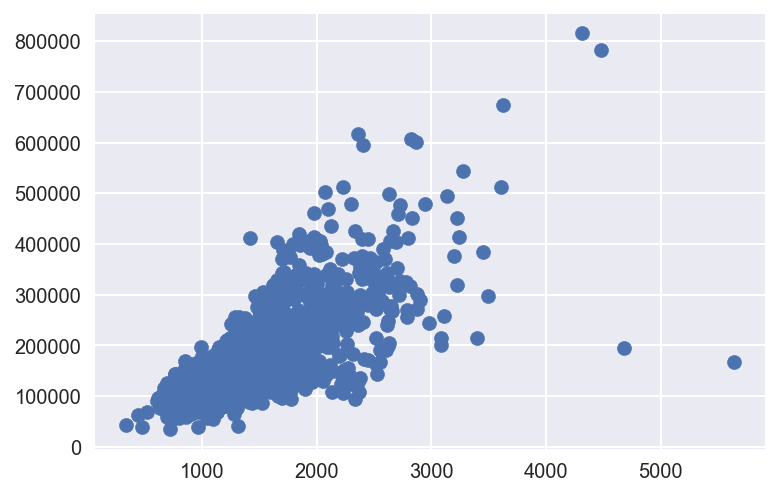

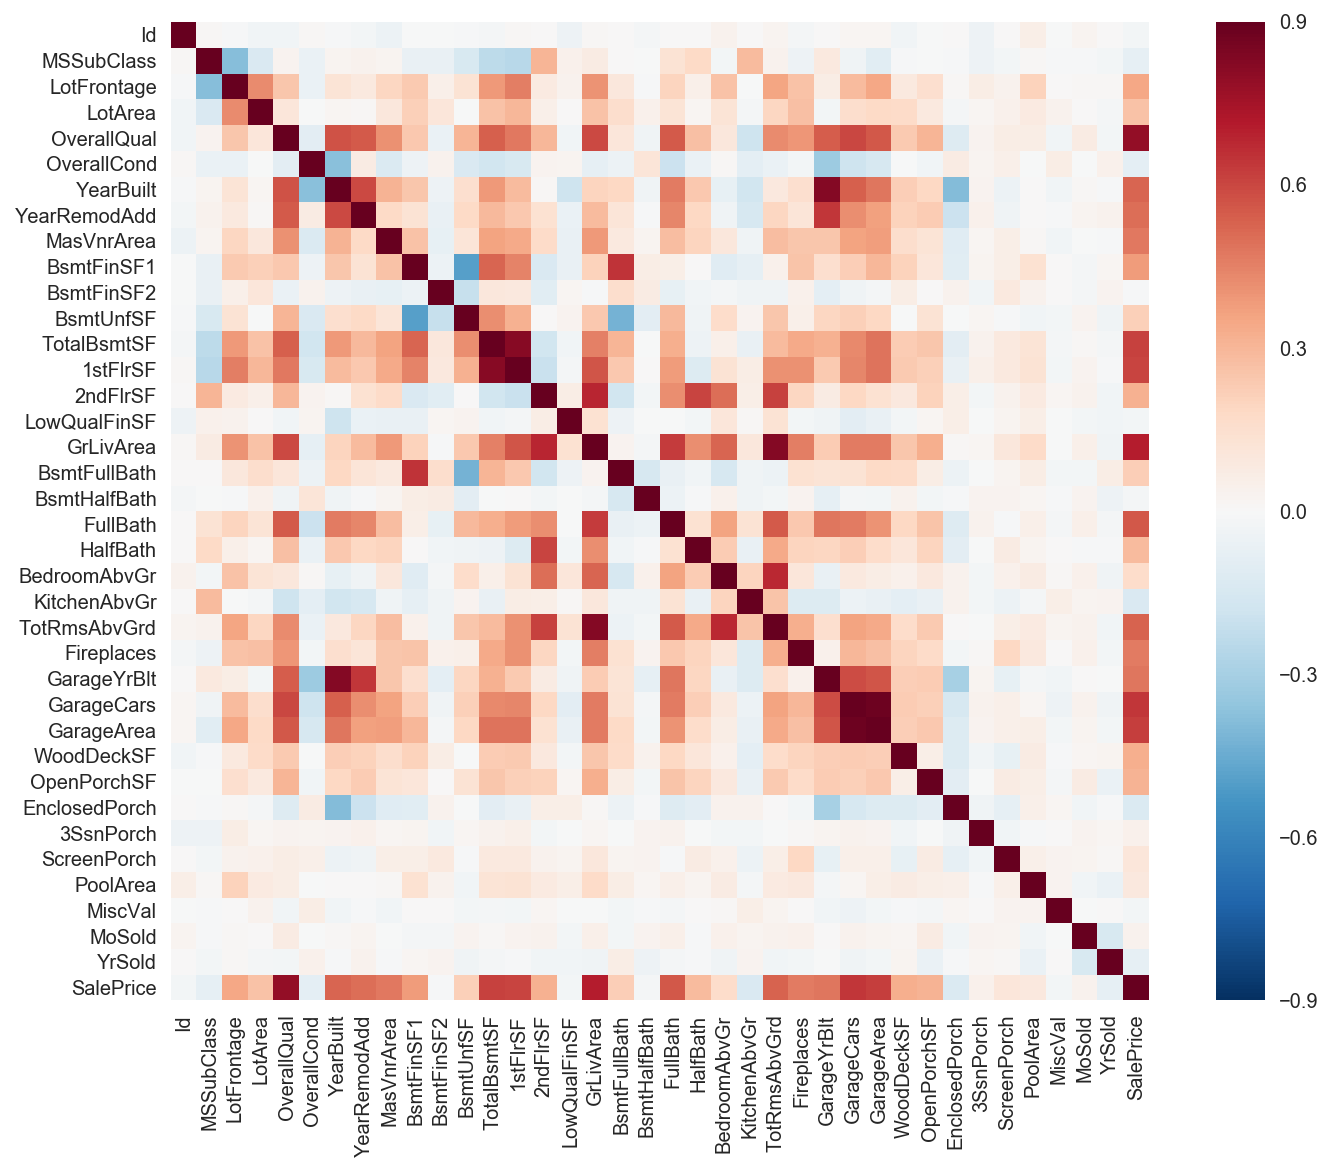

In [94]:
# Plot the correlation of Ground Living Area
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
#Make a correlation map to determine which features are not very correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [95]:
corrmat.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.022606
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.082357
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351366
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.265382
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.787774


In [96]:
corrmat_val = corrmat.ix['SalePrice']
corrmat_val.sort_values(inplace = True, ascending = False)
most_correlated = corrmat_val[1:16]
most_correlated

OverallQual     0.787774
GrLivArea       0.707770
GarageCars      0.639980
GarageArea      0.620738
TotalBsmtSF     0.612814
1stFlrSF        0.605366
FullBath        0.559989
TotRmsAbvGrd    0.533001
YearBuilt       0.522890
YearRemodAdd    0.501783
GarageYrBlt     0.485145
MasVnrArea      0.476032
Fireplaces      0.465131
BsmtFinSF1      0.383484
LotFrontage     0.351366
Name: SalePrice, dtype: float64

In [97]:
core_attributes = []
for x in most_correlated.index:
    core_attributes.append(x)
train_core = train[[x for x in core_attributes]]
train_core

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage
0,7,1710,2,548,856,856,2,8,2003,2003,2003.0,196.0,0,706,65.0
1,6,1262,2,460,1262,1262,2,6,1976,1976,1976.0,0.0,1,978,80.0
2,7,1786,2,608,920,920,2,6,2001,2002,2001.0,162.0,1,486,68.0
3,7,1717,3,642,756,961,1,7,1915,1970,1998.0,0.0,1,216,60.0
4,8,2198,3,836,1145,1145,2,9,2000,2000,2000.0,350.0,1,655,84.0
5,5,1362,2,480,796,796,1,5,1993,1995,1993.0,0.0,0,732,85.0
6,8,1694,2,636,1686,1694,2,7,2004,2005,2004.0,186.0,1,1369,75.0
7,7,2090,2,484,1107,1107,2,7,1973,1973,1973.0,240.0,2,859,NaN
8,7,1774,2,468,952,1022,2,8,1931,1950,1931.0,0.0,2,0,51.0
9,5,1077,1,205,991,1077,1,5,1939,1950,1939.0,0.0,2,851,50.0


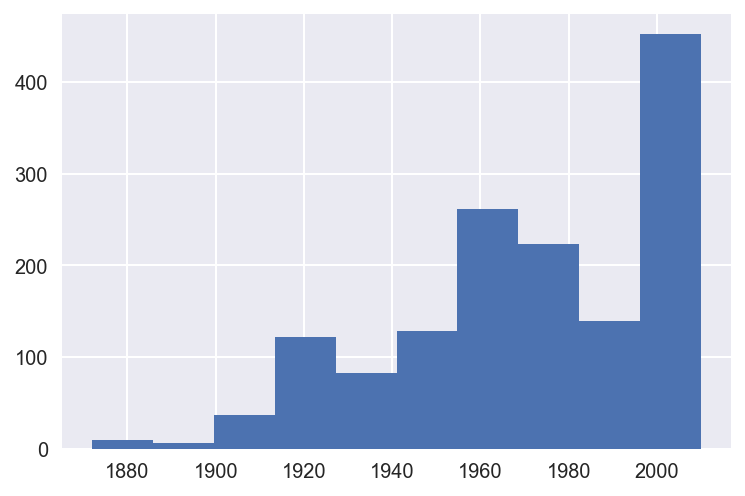

In [99]:
train_core = pd.get_dummies(train_core)
train_core = train_core.fillna(train_core.mean())
train_core['YearBuilt'].hist()